# Heatmap of Hosts

In [1]:
import sys
sys.path.append("../scripts/")
from tree import tree
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import gzip
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [2]:
mgv = pd.read_csv("../Annotations/connector/vpc_mgv.csv", header=0)
mgv_genome = {i.split("_")[0]:"" for i in mgv["protein_id"]}

with gzip.open("../data/mgv_host_assignments.tsv.gz", "r") as f:
    lines = f.readlines()
    for line in lines:
        line = line.decode().strip().split("\t")
        if line[0] in mgv_genome:
            mgv_genome[line[0]] = line[1:]
    
with open("../Annotations/connector/connector_protein.txt", "r") as f:
    lines = f.readlines()
    for line in lines:
        line = line.split(",")
        vpc = line[0]
        for item in line[1:]:
            item = item.split("_")[0] 
            if mgv_genome[item] != "":
                # print(item, mgv_genome[item], vpc)
                mgv_genome[item].append(vpc)
        
# Reformat Dataframe to be "vpc": {hosts...}
clean = {k:v for k,v in mgv_genome.items() if v != ""}
max_length = max(len(arr) for arr in clean.values())
for arr in clean.values():
    arr += [''] * (max_length - len(arr))

df = pd.DataFrame(clean)
df = df.T
df.reset_index(inplace=True)
df.columns = ['contig_id',
 'host_domain',
 'host_phylum',
 'host_class',
 'host_order',
 'host_family',
 'host_genus',
 'host_species', 
 'vpc', 
 'extra']


grouped_df = df.groupby('vpc')
grouped_dict = {vpc:{'contig_id':[],
                    'host_domain':[],
                    'host_phylum':[],
                    'host_class':[],
                    'host_order':[],
                    'host_family':[],
                    'host_genus':[],
                    'host_species':[], 
                    'vpc':[], 
                    'extra':[]} for vpc in df['vpc'].unique()}
for name, group in grouped_df:
    for col in df.columns[1:-1]:
        grouped_dict[name][col] = group[col].values

In [3]:
# Get counts
def get_counts(arr):
    unique_values, counts = np.unique(arr, return_counts=True)
    counts_host = {}
    for value, count in zip(unique_values, counts):
        counts_host[value] = count
    return counts_host

hosts_species = {}
for vpc in grouped_dict.keys():
    hosts_species[vpc] = get_counts(grouped_dict[vpc]["host_species"])

hosts_genus = {}
for vpc in grouped_dict.keys():
    hosts_genus[vpc] = get_counts(grouped_dict[vpc]["host_genus"])

hosts_family = {}
for vpc in grouped_dict.keys():
    hosts_family[vpc] = get_counts(grouped_dict[vpc]["host_family"])

hosts_order = {}
for vpc in grouped_dict.keys():
    hosts_order[vpc] = get_counts(grouped_dict[vpc]["host_order"])


In [4]:
# Summary of all host_family

from collections import Counter

out = Counter()
for val in hosts_family.values():
    tmp = Counter(val)
    out += tmp
out = dict(out)

sorted_dict = dict(sorted(out.items(), key=lambda x: x[1]))

print(sorted_dict)


{'UBA932': 1, 'Aerococcaceae': 1, 'Eubacteriaceae': 1, 'CAG-826': 1, 'QALW01': 1, 'CAG-239': 1, 'Aeromonadaceae': 1, 'Monoglobaceae': 1, 'CAG-274': 1, 'Dysgonomonadaceae': 1, 'UBA1750': 1, 'CAG-611': 1, 'Coprobacteraceae': 1, 'UBA1242': 1, 'Christensenellaceae': 1, 'Moraxellaceae': 1, 'CAG-552': 1, 'CAG-631': 1, 'CAG-314': 2, 'CAG-288': 2, 'Pseudomonadaceae': 2, 'CAG-465': 2, 'Peptoniphilaceae': 3, 'CAG-313': 3, 'UBA1255': 3, 'Treponemataceae': 3, 'UBA1829': 4, 'CAG-307': 4, 'Cellulosilyticaceae': 4, 'Turicibacteraceae': 4, 'Methanobacteriaceae': 4, 'Marinifilaceae': 6, 'Pasteurellaceae': 6, 'CAG-917': 6, 'Gemellaceae': 6, 'CAG-272': 6, 'Neisseriaceae': 7, 'CAG-727': 7, 'Selenomonadaceae': 8, 'Atopobiaceae': 8, 'CAG-1000': 8, 'Barnesiellaceae': 8, 'CAG-822': 9, 'UBA644': 9, 'Megasphaeraceae': 12, 'UBA1381': 12, 'CAG-302': 13, 'Muribaculaceae': 16, 'Porphyromonadaceae': 16, 'Fusobacteriaceae': 16, 'Gastranaerophilaceae': 23, 'Helcococcaceae': 24, 'Desulfovibrionaceae': 24, 'Acidaminococ

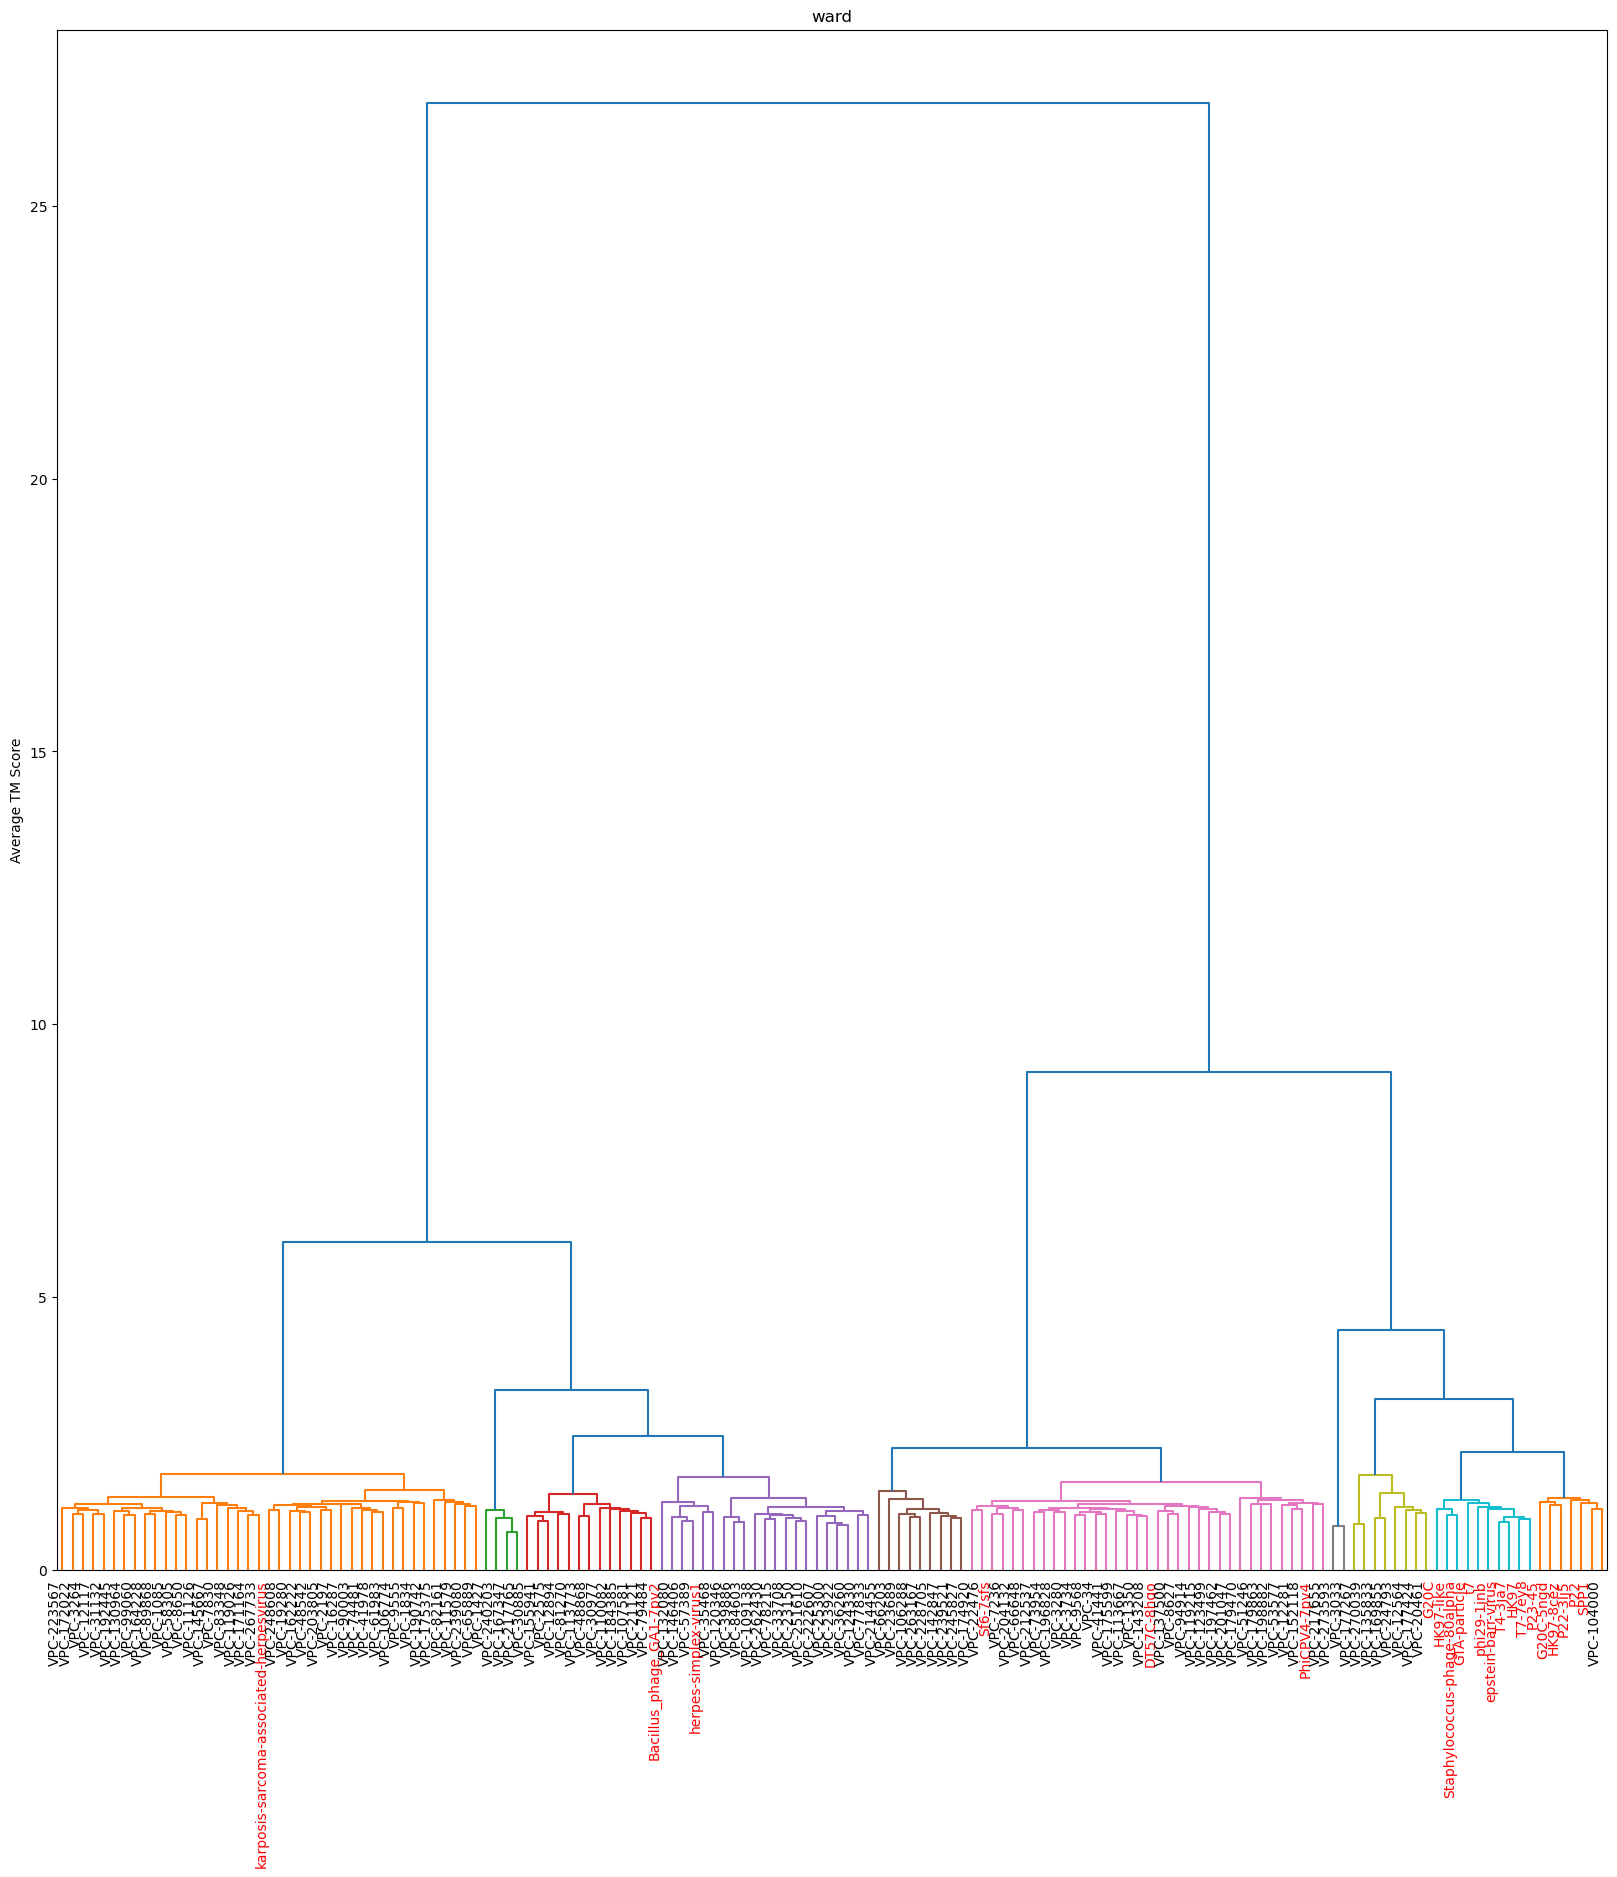

In [5]:
aln_file = "..\Annotations\connector\consensus_pdb\scores1.txt"
tree, dist_matrix, out = tree(aln_file, "ward")
linkage_matrix = linkage(dist_matrix, "ward")
dendro  = dendrogram(linkage_matrix, 
            color_threshold=2, 
            labels=tree.iloc[:,1].unique(), 
            get_leaves=True,
            leaf_rotation=90, 
            no_plot=True)

(83, 150)
(12, 18)


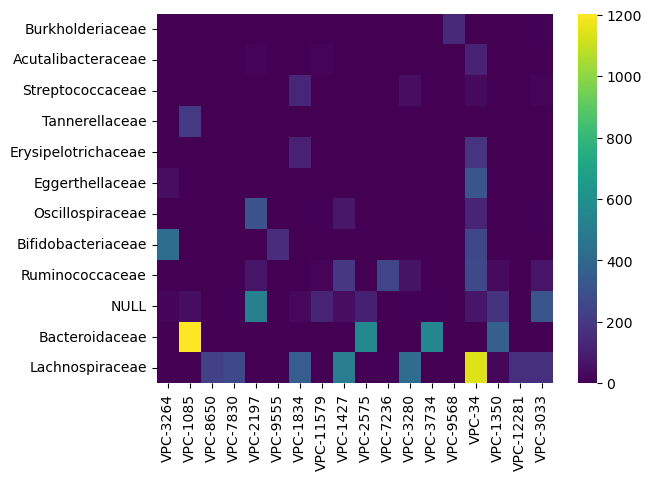

In [6]:
heatmap = pd.DataFrame(columns = dendro["ivl"], index= sorted_dict.keys(), )

for leaf in dendro["ivl"]:
    try:
        # print(f"{leaf}, {hosts_family[leaf]}")
        for fam in hosts_family[leaf]:
            heatmap.loc[fam, leaf] = hosts_family[leaf][fam]
    except:
        # print(leaf)
        pass
heatmap = heatmap.fillna(0)
print(heatmap.shape)
import numpy as np
import pandas as pd

# Identify rows and columns with all 0s
rows_with_all_zeros = heatmap.index[np.all(heatmap < 100, axis=1)]
cols_with_all_zeros = heatmap.columns[np.all(heatmap < 100, axis=0)]

# Remove rows and columns with all 0s
heatmap = heatmap.drop(rows_with_all_zeros, axis=0)
heatmap = heatmap.drop(cols_with_all_zeros, axis=1)
print(heatmap.shape)

# Assuming 'heatmap' is your DataFrame
sns.heatmap(heatmap, cmap='viridis')

plt.show()

In [8]:
# clades
orange = [i for i in range(0, 42)]
green = [i for i in range(42, 46)]
red = [i for i in range(46, 59)]
purple = [i for i in range(59, 80)]
brown = [i for i in range(80, 89)]
pink = [i for i in range(89, 124)]
gray_green = [i for i in range(124, 126)]
green_yellow = [i for i in range(124, 134)]
cyan = [i for i in range(134, 144)]
orange2 = [i for i in range(144, 150)]

def count_hosts(color, host, prop=False, threshold=10):
    out = Counter()
    tot = 0
    for i in color: 
        try:
            tmp = Counter(host[dendro["ivl"][i]])
            out += tmp
        except:
            pass
    out = dict(out)
    out = {k:v for k,v in out.items() if v > threshold}
    # make proportions
    if prop:
        out = {key: value/sum(out.values()) for key, value in out.items()}  
    
    return out
color_dict = {"orange": orange, "green": green, "red": red, "purple": purple, "brown": brown, "pink": pink, "gray_green": gray_green, "green_yellow": green_yellow, "cyan": cyan, "orange2": orange2}
color_order = {}
color_family = {}
color_genus = {}

for k,v in color_dict.items():
    color_order[k] = count_hosts(v, hosts_order, threshold = 150)
    color_family[k] = count_hosts(v, hosts_family, threshold = 150)
    color_genus[k] = count_hosts(v, hosts_genus, threshold = 150)


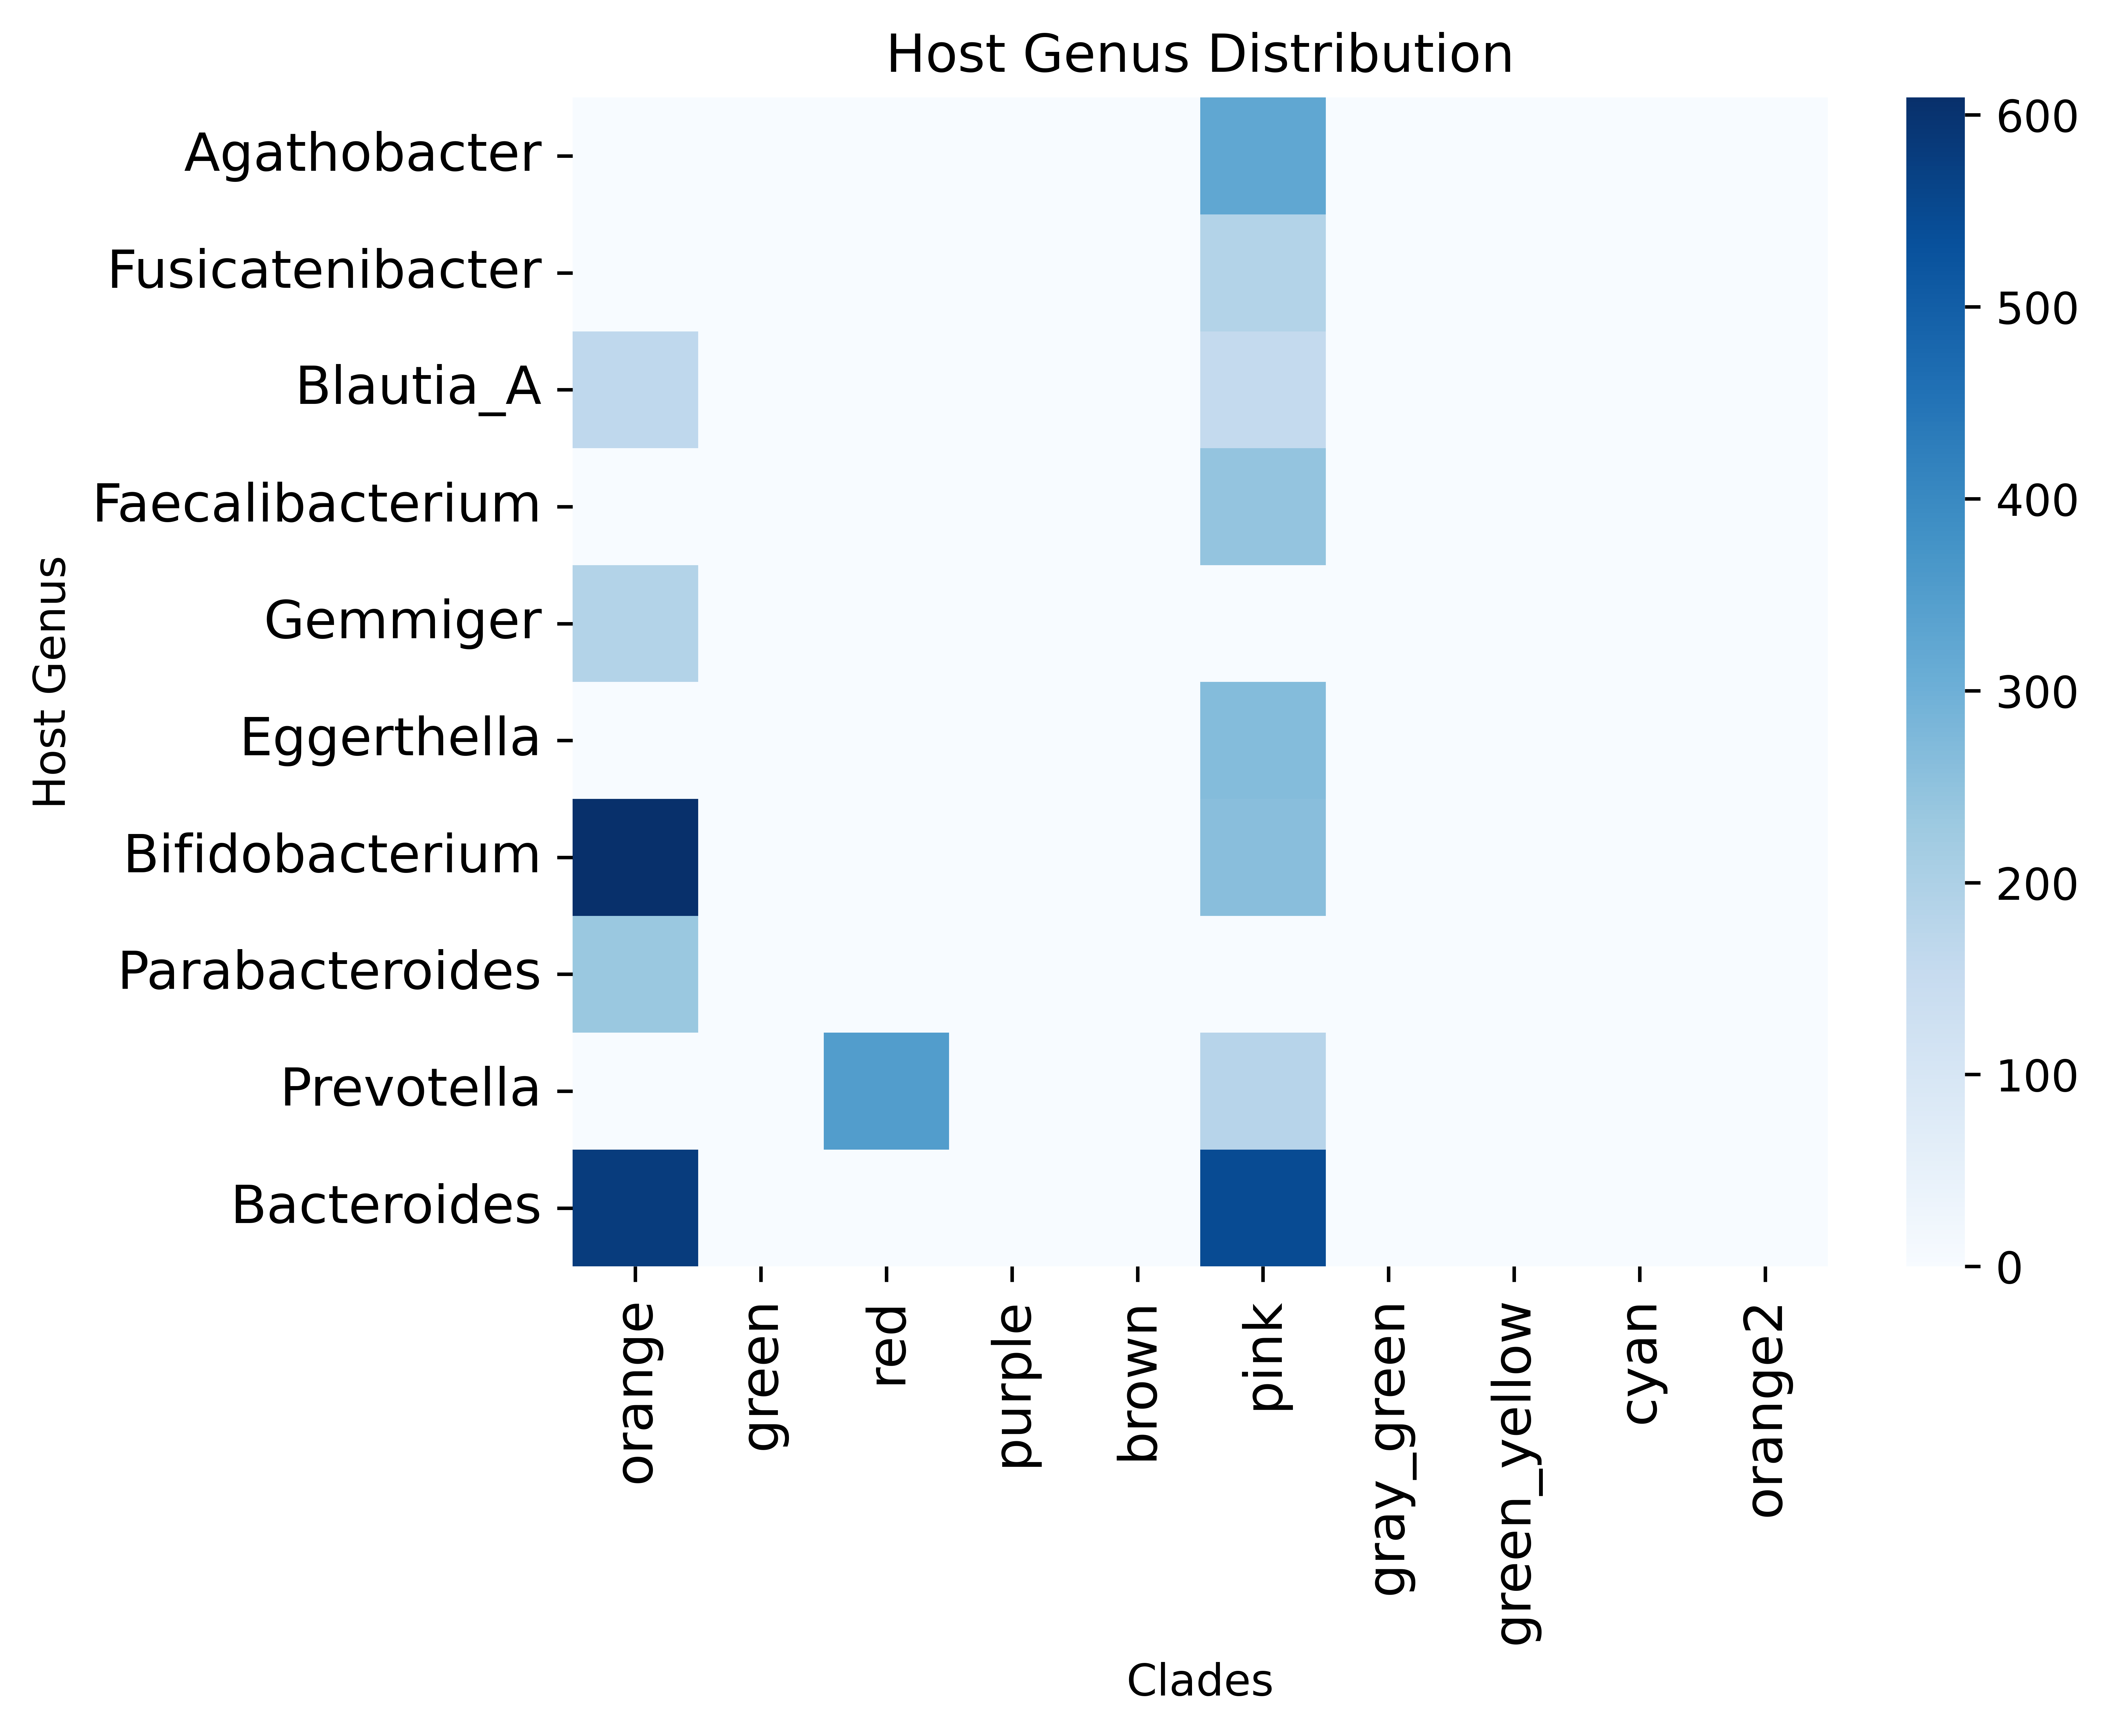

In [10]:

tmp = pd.DataFrame(color_genus).fillna(0)
tmp = tmp.drop("NULL")
tmp.index = pd.CategoricalIndex(tmp.index, categories= ["Agathobacter" ,"Fusicatenibacter" ,"Blautia_A" ,"Faecalibacterium" ,"Gemmiger" ,"Eggerthella" ,"Bifidobacterium" ,"Parabacteroides" ,"Prevotella" ,"Bacteroides"])
tmp.sort_index(level=0, inplace=True)
# tmp = tmp.drop("NULL")
# tmp.fillna(0, inplace=True)
plt.figure(dpi=1000)
sns.heatmap(tmp, cmap="Blues", xticklabels=True, yticklabels=True)
plt.title("Host Genus Distribution")
plt.xlabel("Clades")
plt.ylabel("Host Genus")
ax = plt.gca()
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.show()

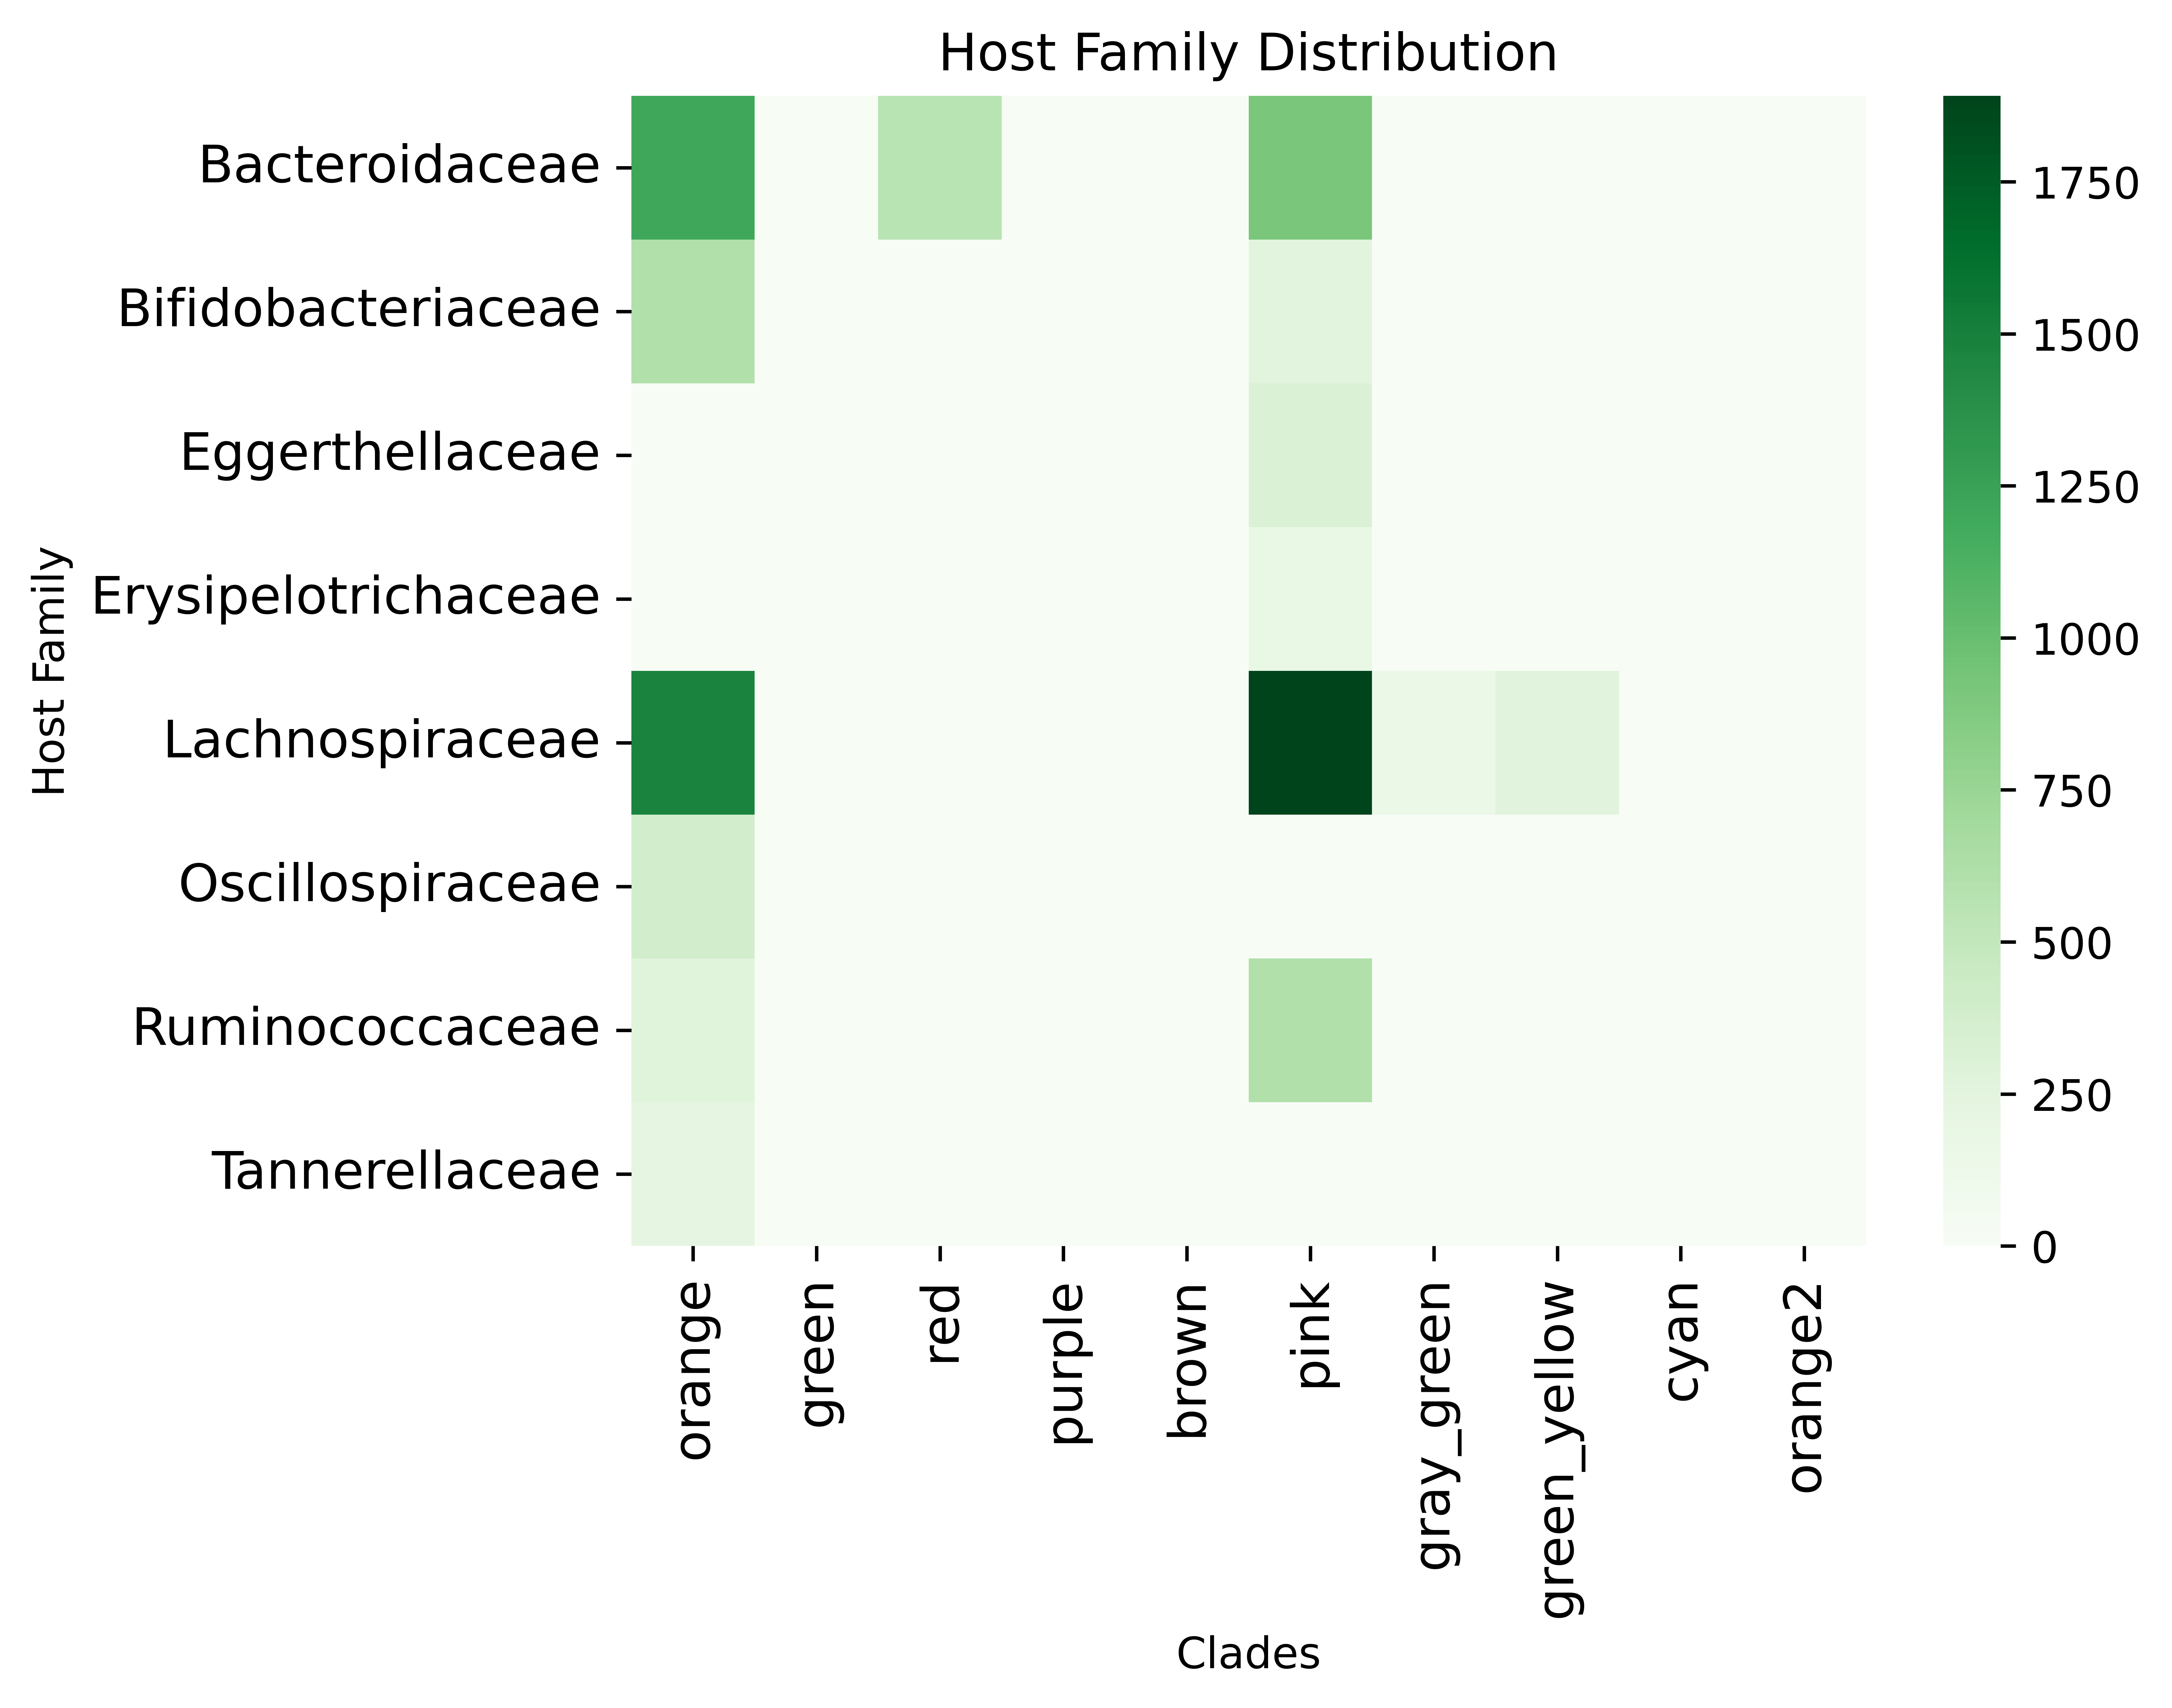

In [12]:

tmp = pd.DataFrame(color_family).fillna(0)
tmp = tmp.drop("NULL")
tmp.sort_index(level=0, inplace=True)
# tmp = tmp.drop("NULL")
# tmp.fillna(0, inplace=True)
plt.figure(dpi=1000)
sns.heatmap(tmp, cmap="Greens", xticklabels=True, yticklabels=True)
plt.title("Host Family Distribution")
plt.xlabel("Clades")
plt.ylabel("Host Family")
ax = plt.gca()
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.show()

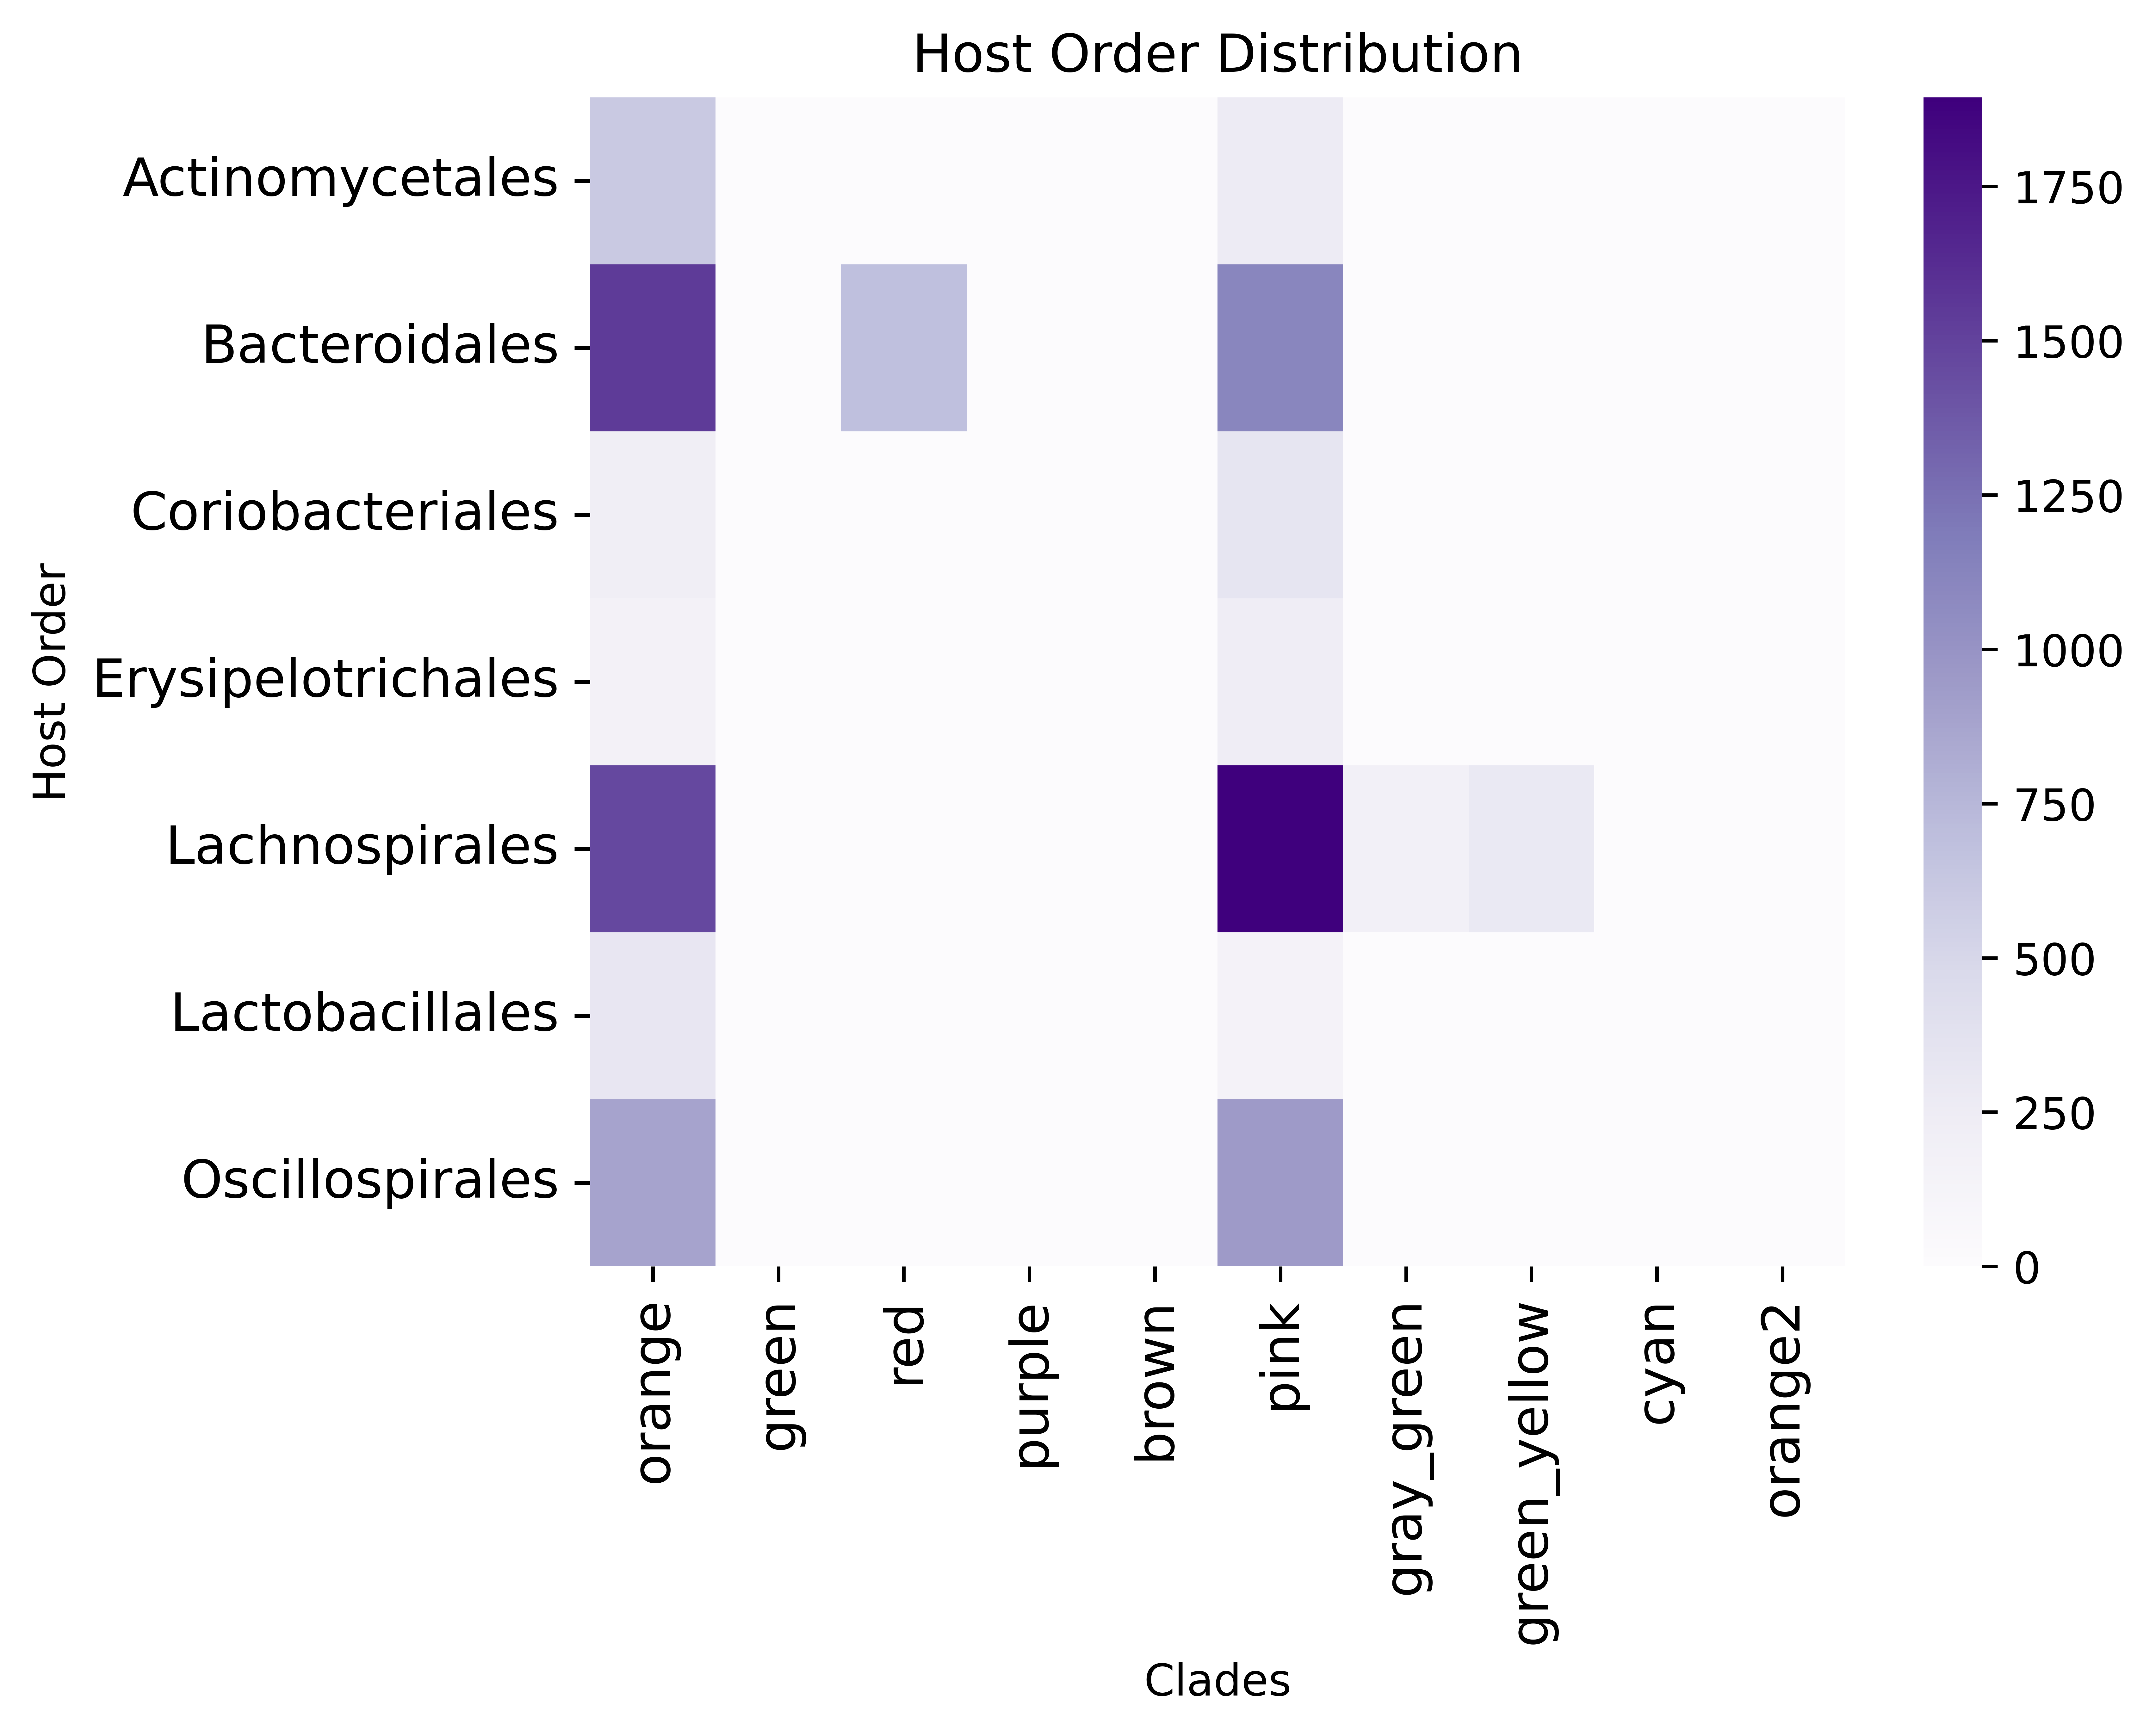

In [13]:

tmp = pd.DataFrame(color_order).fillna(0)
tmp = tmp.drop("NULL")
tmp.sort_index(level=0, inplace=True)
# tmp = tmp.drop("NULL")
# tmp.fillna(0, inplace=True)
plt.figure(dpi=1000)
sns.heatmap(tmp, cmap="Purples", xticklabels=True, yticklabels=True)
plt.title("Host Order Distribution")
plt.xlabel("Clades")
plt.ylabel("Host Order")
ax = plt.gca()
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.show()